In [262]:
import re
import numpy as np
import pandas as pd
from os import path
from collections import Counter
from glob import glob
from lxml import etree
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import string
import spacy

In [284]:
df_corpus = pd.read_csv(r'../meta_data/corpus.csv')
#df_meta_data = pd.read_csv(r'../meta_data/meta_data_canons.csv')
df_meta_data = pd.read_csv(r'../meta_data/meta_data_last_version.csv')
df_corpus_canon = pd.read_csv(r'../meta_data/corpus_canons.csv')

#### Get list doc name & gender & auteur_canon from metadata/corpus.csv

In [285]:
list_doc_name = df_corpus.doc_name
list_auteur = df_corpus.auteur
list_titre = df_corpus.titre
list_date = df_corpus.date
list_gender = df_corpus.gender
list_auteur_canon = df_corpus.canon

#### Get list roman_canon from metadata/corpus_canon.csv

In [286]:
list_roman_canon = df_corpus_canon.canon

#### Get lists presence in canon ? 0, 1 from metadata/meta_data_canons.csv

In [287]:
def get_list_presence_roman(list_titre, df_meta_data, feature_wanted):
    list_feature_wanted = []
    for elem in list_titre:
        if feature_wanted not in list(df_meta_data.columns):
            print('feature_wanted do not exist')
            return
        else :
            if elem in list(df_meta_data[feature_wanted]):
                list_feature_wanted.append(1)                
            else:
                list_feature_wanted.append(0)
    return list_feature_wanted

In [288]:
list_bac = get_list_presence_roman(list_titre, df_meta_data, 'bac')
list_brevet = get_list_presence_roman(list_titre, df_meta_data, 'brevet')
list_lm = get_list_presence_roman(list_auteur, df_meta_data, 'lm')
list_sup = get_list_presence_roman(list_titre, df_meta_data, 'sup')
list_prix = get_list_presence_roman(list_titre, df_meta_data, 'prix')
list_gf = get_list_presence_roman(list_titre, df_meta_data, 'gf')
list_pleiade = get_list_presence_roman(list_auteur, df_meta_data, 'pleiade')
list_gouv = get_list_presence_roman(list_titre, df_meta_data, 'gouv')

In [307]:
list_roman_canon = ['canon' if (row['bac']==1) | (row['brevet']==1) | (row['sup']==1) | (row['prix']==1) | (row['gf']==1) | (row['gouv']==1) else 'non_canon' for index, row in df_canon_spec.iterrows()]

In [309]:
zipped = list(zip(list_doc_name, list_date, list_auteur, list_titre, list_roman_canon, list_auteur_canon, list_gender, list_bac, list_brevet, list_lm, list_sup, list_prix, list_gf, list_pleiade, list_gouv))

In [310]:
df_canon_spec = pd.DataFrame(zipped, columns=["doc_name", "date", "auteur", "titre", "canon_roman", "canon_auteur", "gender", "bac", "brevet", "lm", 'sup', 'prix', 'gf', 'pleiade', 'gouv'])

In [311]:
df_canon_spec.to_csv(r'../meta_data/df_canon_spec_last.csv', index=False)

In [312]:
df_canon_spec

,doc_name,date,auteur,titre,canon_roman,canon_auteur,gender,bac,brevet,lm,sup,prix,gf,pleiade,gouv
0,1811_Chateaubriand-François-Rene-de_Oeuvres-co...,1811,françois rene de chateaubriand,oeuvres completes,canon,canon,male,0,0,0,1,0,0,0,1
1,1812_Kock-Paul-de_L-enfant-de-ma-femme,1812,paul de kock,l enfant de ma femme,non_canon,non-canon,male,0,0,0,0,0,0,0,0
2,1815_Gay-Sophie_Anatole_Vol-2,1815,sophie gay,anatole,non_canon,non-canon,female,0,0,0,0,0,0,0,0
3,1815_Gay-Sophie_Anatole_Vol-1,1815,sophie gay,anatole,non_canon,non-canon,female,0,0,0,0,0,0,0,0
4,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,1816,hadot marie adelaide barthelemy,la vierge de l indostan ou les portugais au ma...,non_canon,non-canon,female,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,2018_Murail-Marie-Aude_En-nous-beaucoup-d-homm...,2018,marie aude murail,en nous beaucoup d hommes respirent,non_canon,non-canon,female,0,0,0,0,0,0,0,0
2956,2019_Dabos-Christelle_La-Passe-miroir_4-La-Tem...,2019,christelle dabos,la passe miroir,non_canon,non-canon,female,0,0,0,0,0,0,0,0
2957,2019_Murail-Marie-Aude_Sauveur-Fils_5,2019,marie aude murail,sauveur fils,non_canon,non-canon,female,0,0,0,0,0,0,0,0
2958,2020_Melois-Clementine_Dehors-la-tempete,2020,clementine melois,dehors la tempete,non_canon,non-canon,female,0,0,0,0,0,0,0,0


In [296]:
df_canon_NOVEL_SCALE = df_canon_spec[(df_canon_spec['bac']==1) | (df_canon_spec['brevet']==1) | (df_canon_spec['sup']==1) | (df_canon_spec['prix']==1) | (df_canon_spec['gf']==1) | (df_canon_spec['gouv']==1)]

In [297]:
df_canon_NOVEL_SCALE.to_csv(r'../meta_data/df_canon_NOVEL_SCALE.csv')

In [298]:
len(df_canon_NOVEL_SCALE)

300

In [223]:
df_canon_AUTEUR_SCALE = df_canon_spec[(df_canon_spec['lm']==1) | (df_canon_spec['pleiade']==1) | (df_canon_spec['canon_auteur']==True)]

In [224]:
df_canon_AUTEUR_SCALE.to_csv(r'../meta_data/df_canon_AUTEUR_SCALE.csv')

In [225]:
len(df_canon_AUTEUR_SCALE)

747

In [313]:
df_canon_spec.canon_roman.value_counts()[1]

300

In [226]:
df_canon_spec.bac.value_counts()[1]

97

In [227]:
df_canon_spec.brevet.value_counts()[1]

51

In [228]:
df_canon_spec.sup.value_counts()[1]

39

In [229]:
df_canon_spec.prix.value_counts()[1]

90

In [230]:
df_canon_spec.gouv.value_counts()[1]

44

In [231]:
df_canon_spec.gf.value_counts()[1]

112

In [178]:
def prep_list_graph(df_canon_spec, list_factors):
    list_res_factors = []
    for col in df_canon_spec.columns:
        if col in list_factors:
            list_res_factors.append(df_canon_spec[col].value_counts()[1])
    return list_res_factors

In [232]:
list_factors = ["bac", "brevet", 'sup', 'prix', 'gf', 'gouv']

In [233]:
list_res_factors = prep_list_graph(df_canon_spec, list_factors)

/home/crazyjeannot/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


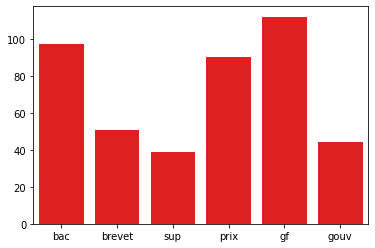

In [234]:
ax = sns.barplot(list_factors, list_res_factors, color = 'red')

In [235]:
df_canon_spec.pleiade.value_counts()[1]

634

In [236]:
df_canon_spec.lm.value_counts()[1]

555

In [237]:
len(df_meta_data['sup'].dropna())

259

### TABLEAU len(liste) & len(canon_liste)

In [203]:
str_join = ' '
list_res = []
for elem in liste_canon_2:
    temp = elem.split('-')
    list_res.append(str_join.join(temp).lower())

In [204]:
list_res

['oeuvres completes',
 'adolphe',
 'le solitaire',
 'le dernier jour d un condamne',
 'le rouge et le noir',
 'notre dame de paris',
 'notre dame de paris',
 'stello',
 'volupte',
 'claude gueux',
 'volupte',
 'mademoiselle de maupin',
 'la confession d un enfant du siecle',
 'la chartreuse de parme',
 'pauline',
 'la femme de trente ans',
 'beatrix',
 'le contrat de mariage',
 'le corricolo',
 'le cure de tours',
 'le pere goriot',
 'illusions perdues',
 'pierrette',
 'eugenie grandet',
 'le colonel chabert',
 'splendeurs et miseres des courtisanes',
 'vie de rance',
 'le lys dans la vallee',
 'les trois mousquetaires',
 'le comte de monte cristo',
 'un debut dans la vie',
 'adieu',
 'vingt ans apres',
 'la reine margot',
 'la mare au diable',
 'physiologie du mariage',
 'isabelle',
 'louis lambert',
 'une tenebreuse affaire',
 'le cure de village',
 'la dame de monsoreau',
 'le medecin de campagne',
 'la dame aux camelias',
 'memoires d outre tombe',
 'memoires d outre tombe',
 'memo

In [276]:
list_canon_1 = list(df_canon_NOVEL_SCALE.titre)

In [277]:
len(list_canon_1)

299

In [278]:
len(liste_canon_2)

261

In [279]:
canon1 = [x for x in list_canon_1 if x not in list_res]

In [280]:
len(canon1)

42

In [281]:
canon2 = [x for x in list_res if x not in list_canon_1]

In [282]:
len(canon2)

4

In [283]:
canon2

['le corricolo', "l'homme qui rit", 'clair de lune', 'la maison']

In [31]:
len(set(list(df_canon_spec.auteur)))

714

In [32]:
2961/710

4.170422535211268

In [ ]:
len(set(list(df_canon_female.auteur)))

In [ ]:
len(df_canon_female)/len(set(list(df_canon_female.auteur)))

<AxesSubplot:xlabel='pleiade', ylabel='lm'>

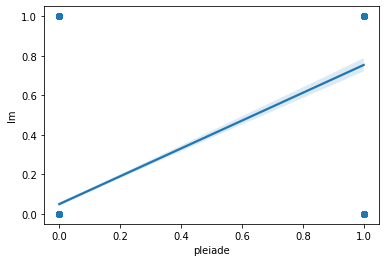

In [249]:
sns.regplot(data=df_canon_spec, x="pleiade", y="lm")

In [250]:
np.corrcoef(df_canon_spec['pleiade'], df_canon_spec['lm'])

array([[1.        , 0.71634589],
       [0.71634589, 1.        ]])

In [251]:
pearsonr(df_canon_spec['pleiade'], df_canon_spec['lm'])

(0.7163458882624895, 0.0)

<AxesSubplot:xlabel='gf', ylabel='bac'>

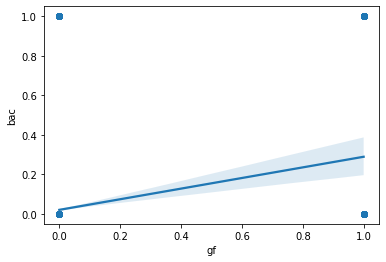

In [252]:
sns.regplot(data=df_canon_spec, x="gf", y="bac")

<AxesSubplot:xlabel='brevet', ylabel='sup'>

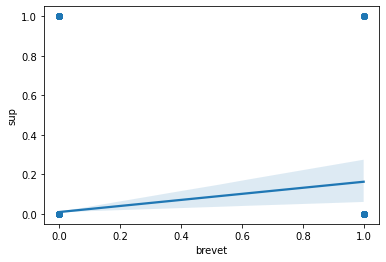

In [253]:
sns.regplot(data=df_canon_spec, x="brevet", y="sup")

In [254]:
np.corrcoef(df_canon_spec['gf'], df_canon_spec['gouv'])

array([[1.        , 0.35565507],
       [0.35565507, 1.        ]])

### Compute Cosine similarity between lists 

In [315]:
list_factors = ["bac", "brevet", 'sup', 'prix', 'gf', 'gouv']

In [316]:
def cosine_sim_vectors(vec1, vec2):
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    
    return cosine_similarity(vec1, vec2)[0][0]

In [318]:
def compute_cs(list_facteur, df_canon_NOVEL_SCALE):
    list_bac, list_brevet, list_sup, list_prix, list_gf, list_gouv, list_roulante = [],[],[],[],[],[],[]
    for facteur in list_facteur:
        for facteur_2 in list_facteur:
            
            list_roulante.append(cosine_sim_vectors(np.array(df_canon_NOVEL_SCALE[facteur]), np.array(df_canon_NOVEL_SCALE[facteur_2])))
        
        if facteur == 'bac':
            list_bac = list_roulante
        elif facteur == 'brevet':
            list_brevet = list_roulante
        elif facteur == 'sup':
            list_sup = list_roulante
        elif facteur == 'prix':
            list_prix = list_roulante
        elif facteur == 'gf':
            list_gf = list_roulante
        elif facteur == 'gouv':
            list_gouv = list_roulante
            
        list_roulante = []

    zipped = list(zip(list_bac, list_brevet, list_sup, list_prix, list_gf, list_gouv))
    return pd.DataFrame(zipped, columns=list_facteur, index=list_facteur)

In [319]:
df_cs = compute_cs(list_factors, df_canon_NOVEL_SCALE)

In [320]:
df_cs

,bac,brevet,sup,prix,gf,gouv
bac,1.000000,0.381914,0.323508,0.106479,0.324532,0.152286
brevet,0.381914,1.000000,0.134535,0.103322,0.224934,0.105550
sup,0.323508,0.134535,1.000000,0.067516,0.242091,0.168982
prix,0.106479,0.103322,0.067516,1.000000,0.009960,0.000000
gf,0.324532,0.224934,0.242091,0.009960,1.000000,0.299147
gouv,0.152286,0.105550,0.168982,0.000000,0.299147,1.000000


### SKlearn Heat Map

In [321]:
import matplotlib.pyplot as plt

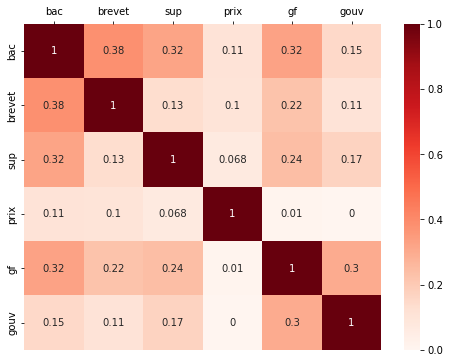

In [324]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(df_cs, cmap="Reds", annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()